In [4]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
import random
import sys
import seaborn as sns
import pandas as pd
from scipy import stats
import os
from sklearn.mixture import GaussianMixture
import math

In [5]:
def get_data_in_dataframe(function_to_ages,ages_list):
    data = [] #function, ages_list, mean, std, len, rand_mean, rand_std
    for func in function_to_ages:
        curr = []
        ages = np.array(function_to_ages[func])
        
        #remove Nones
        ages = ages[ages != np.array(None)]
        if len(ages) == 0:
            continue
            
        #calculation of stats
        curr.append(func)
        curr.append(ages)
        curr.append(np.mean(ages))
        curr.append(np.std(ages))
        curr.append(len(ages))
        if len(set(ages)) > 2:
            g = GaussianMixture(2)
            covs = g.fit(ages.reshape(-1,1)).covariances_
            std1 = math.sqrt(covs[0][0][0])
            std2 = math.sqrt(covs[1][0][0])
            curr.append(std1)
            curr.append(std2)
            curr.append((std1+std2)/2.0)
        else:
            curr.append(0)
            curr.append(0)
            curr.append(0)
        
            
        #random (based on num ages)
        rand_ages = np.array(random.sample(ages_list,len(ages)))
        curr.append(np.mean(rand_ages))
        curr.append(np.std(rand_ages))
        if len(set(rand_ages)) > 2:
            g = GaussianMixture(2)
            covs = g.fit(rand_ages.reshape(-1,1)).covariances_
            std1 = math.sqrt(covs[0][0][0])
            std2 = math.sqrt(covs[1][0][0])
            curr.append(std1)
            curr.append(std2)
            curr.append((std1+std2)/2.0)
        else:
            curr.append(0)
            curr.append(0)
            curr.append(0)
        data.append(curr)
        
    df = pd.DataFrame(data)
    df.columns = ['function_name','ages_list',
                  'age_mean','age_std','num_els',
                  'age_gmm2_std1', 'age_gmm2_std2','age_gmm2_std_avg',
                  'rand_age_mean','rand_age_std', 'rand_age_gmm2_std_avg',
                  'rand_age_gmm2_std1','rand_age_gmm2_std2']
    return df

In [6]:
def violin(ax,df,col1,col2,label=None): #grouped by size
    if label == None:
        label = col1
    len_list = df['num_els'].tolist()
    std_list = df[col1].tolist()
    rand_std_list = df[col2].tolist()
    
    lq = np.percentile(len_list,25)
    mq = np.percentile(len_list,50)
    uq = np.percentile(len_list,75)  
    
    len_dict_func_std_list = {}
    len_dict_rand_std_list = {}

    for i in range(0,len(std_list)):
        l = len_list[i]
        if l not in len_dict_func_std_list:
            len_dict_func_std_list[l] = []
            len_dict_rand_std_list[l] = []
        len_dict_func_std_list[l].append(std_list[i])
        len_dict_rand_std_list[l].append(rand_std_list[i])

    len_func_stds = []
    len_rand_stds = []
    len_order_list = []
    for l in len_dict_func_std_list:
        len_func_stds.append(np.mean(len_dict_func_std_list[l]))
        len_rand_stds.append(np.mean(len_dict_rand_std_list[l]))
        len_order_list.append(l)
    
    
    v_data = []
    for l in len_dict_func_std_list:
        if l < lq:
            for s in len_dict_func_std_list[l]:
                v_data.append(["<%d"%lq,s,"Func"])
            for s in len_dict_rand_std_list[l]:
                v_data.append(["<%d"%lq,s,"Rand"])
        elif l < mq:
            for s in len_dict_func_std_list[l]:
                v_data.append(["<%d"%mq,s,"Func"])
            for s in len_dict_rand_std_list[l]:
                v_data.append(["<%d"%mq,s,"Rand"])
        elif l < uq:
            for s in len_dict_func_std_list[l]:
                v_data.append(["<%d"%uq,s,"Func"])
            for s in len_dict_rand_std_list[l]:
                v_data.append(["<%d"%uq,s,"Rand"])
        else:
            for s in len_dict_func_std_list[l]:
                v_data.append(["Largest",s,"Func"])
            for s in len_dict_rand_std_list[l]:
                v_data.append(["Largest",s,"Rand"])

    
    v_df = pd.DataFrame(v_data,columns = ["GeneSet",label,"Type"])
    sns.violinplot(x="GeneSet",y=label,data=v_df,ax=ax, order = ["<%d"%lq,"<%d"%mq ,"<%d"%uq,"Largest"],hue="Type",palette="muted",split=True,legend=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, rotation_mode="anchor")
    

    print ("<%d"%lq, stats.wilcoxon(v_df[v_df['Type']=="Func"][v_df["GeneSet"] == "<%d"%lq][label], v_df[v_df['Type']=="Rand"][v_df["GeneSet"] == "<%d"%lq][label]))
    print ("<%d"%mq, stats.wilcoxon(v_df[v_df['Type']=="Func"][v_df["GeneSet"] == "<%d"%mq][label], v_df[v_df['Type']=="Rand"][v_df["GeneSet"] == "<%d"%mq][label]))
    print ("<%d"%uq, stats.wilcoxon(v_df[v_df['Type']=="Func"][v_df["GeneSet"] == "<%d"%uq][label], v_df[v_df['Type']=="Rand"][v_df["GeneSet"] == "<%d"%uq][label]))
    print ("Largest", stats.wilcoxon(v_df[v_df['Type']=="Func"][v_df["GeneSet"] == "Largest"][label], v_df[v_df['Type']=="Rand"][v_df["GeneSet"] == "Largest"][label]))
    

In [7]:
# GET FUNC GROUPED AGE DATA
function_to_ages = pickle.load(open("data/function_to_age_simplified_dict.p","rb"))

gene_to_age_dict = pickle.load(open("data/gene_to_age_simplified_dict.p","rb"))
ages_list = []
for gene in gene_to_age_dict:
    ages_list.append(gene_to_age_dict[gene])
    
df = get_data_in_dataframe(function_to_ages,ages_list)

In [8]:
df

,function_name,ages_list,age_mean,age_std,num_els,age_gmm2_std1,age_gmm2_std2,age_gmm2_std_avg,rand_age_mean,rand_age_std,rand_age_gmm2_std_avg,rand_age_gmm2_std1,rand_age_gmm2_std2
0,domain:Beta/gamma crystallin 'Greek key' 1,"[0.375, 0.1, 1.0, 1.0, 0.5, 0.1]",0.512500,0.372981,6,0.174445,0.001000,0.087723,0.646429,0.296916,0.136888,0.117344,0.127116
1,Pyrrolidone carboxylic acid,"[0.3333333333333333, 1.0, 0.6666666666666666, ...",0.685317,0.372547,26,0.001000,0.282181,0.141590,0.625841,0.342823,0.001000,0.300638,0.150819
2,GO:0035335~peptidyl-tyrosine dephosphorylation,"[1.0, 0.8888888888888888, 0.5555555555555556, ...",0.419725,0.340783,26,0.001000,0.264948,0.132974,0.564530,0.374689,0.243655,0.058190,0.150922
3,Cytoplasm,"[0.75, 0.7142857142857143, 0.3333333333333333,...",0.551929,0.368894,1541,0.001000,0.301281,0.151141,0.549159,0.358165,0.175817,0.203934,0.189875
4,region of interest:Triple-helical region 2 (COL2),"[0.25, 0.75, 0.5714285714285714, 0.0]",0.392857,0.289043,4,0.125801,0.089318,0.107559,0.035714,0.061859,0.000000,0.000000,0.000000
5,"IPR002219:Protein kinase C-like, phorbol ester...","[0.6, 1.0, 1.0, 0.6666666666666666, 1.0, 0.375...",0.796026,0.246884,20,0.149865,0.001000,0.075433,0.540335,0.324112,0.205166,0.050817,0.127991
6,DNA-binding region:Basic motif,"[0.7142857142857143, 0.25, 0.5714285714285714,...",0.445647,0.308590,67,0.158707,0.220681,0.189694,0.568707,0.348082,0.052190,0.269524,0.160857
7,GO:0007286~spermatid development,"[0.5555555555555556, 1.0, 1.0, 0.5555555555555...",0.530159,0.362625,19,0.267465,0.001000,0.134232,0.461550,0.320112,0.213744,0.072199,0.142971
8,GO:0030054~cell junction,"[0.0, 0.75, 0.4444444444444444, 0.375, 0.77777...",0.559310,0.328683,254,0.270345,0.001000,0.135673,0.549895,0.357529,0.089634,0.260992,0.175313
9,GO:0033268~node of Ranvier,"[1.0, 1.0, 1.0, 0.25, 1.0, 0.3333333333333333,...",0.726190,0.323407,7,0.001000,0.103940,0.052470,0.614286,0.379581,0.001000,0.238551,0.119775


/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key w

<6 WilcoxonResult(statistic=28418.0, pvalue=1.0986100003435015e-33)
<10 WilcoxonResult(statistic=35334.0, pvalue=4.751282586485736e-40)
<25 WilcoxonResult(statistic=59598.0, pvalue=1.3955468662631953e-16)
Largest WilcoxonResult(statistic=60849.0, pvalue=3.394172043800099e-11)


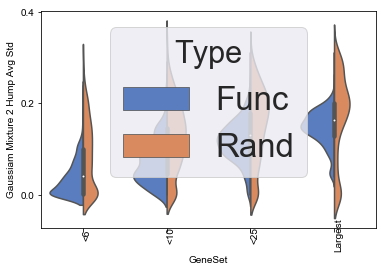

In [9]:
fig, ax = plt.subplots(1, 1 , sharex=False, sharey=False)
sns.set(font_scale=3)
violin(ax ,df,'age_gmm2_std_avg','rand_age_gmm2_std_avg','Gaussiam Mixture 2 Hump Avg Std')
plt.savefig("figures/violin_gaussian_mixture_bimodal_avg_std.png")

In [11]:
pickle.dump(df,open("data/basic_df.p","wb"))